In [ ]:
# Thư viện chung 
import os, sys, platform, glob, itertools, time, io, base64
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report

## 1. Đường dẫn & tham số

In [ ]:

DATA_DIR   = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\HoangAnh\chest_xray_v2"
TRAIN_DIR  = os.path.join(DATA_DIR, "train")
VAL_DIR    = os.path.join(DATA_DIR, "val")
TEST_DIR   = os.path.join(DATA_DIR, "test")

PROJECT_DIR = os.path.join(os.path.dirname(DATA_DIR), "xception_project")
CKPT_DIR    = os.path.join(PROJECT_DIR, "checkpoints")
OUT_DIR     = os.path.join(PROJECT_DIR, "outputs")
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Kích thước & cấu hình siêu cao
IMG_SIZE   = (299, 299)  #  Chuẩn Xception
BATCH_SIZE = 32
EPOCHS     = 50
SEED       = 42
CLASSES    = ('NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus')

BEST_MODEL_PATH = os.path.join(CKPT_DIR, "xception_pneu_best.h5")
CSV_LOG_PATH    = os.path.join(CKPT_DIR, "train_log.csv")

## 2. DATA (tf.data, light mode)

In [ ]:
def make_ds(data_dir, shuffle=True):
    ds = image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',        # 3 lớp -> one-hot
        class_names=list(CLASSES),       # cố định thứ tự nhãn
        image_size=IMG_SIZE,             # 299x299
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED)
    return ds

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR,   shuffle=False)
test_ds  = make_ds(TEST_DIR,  shuffle=False)

def preprocess_map(x, y):
    x = tf.cast(x, tf.float32)
    x = xception_preprocess(x)          # đúng chuẩn Xception
    return x, y

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess_map, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess_map,   num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess_map,  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print("Classes:", CLASSES)

Found 9097 files belonging to 3 classes.
Found 1359 files belonging to 3 classes.
Found 1355 files belonging to 3 classes.
Classes: ('NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus')


## 3. Xây mô hình Xception

In [4]:
def build_xception(num_classes=3, dropout=0.35, l2=1e-5):
    base = Xception(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
    base.trainable = False  # Phase 1: đóng băng backbone

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    return models.Model(base.input, out, name="xception_pneu")

model = build_xception(num_classes=len(CLASSES))
model.summary()

Model: "xception_pneu"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                     

## 4.Compile & hàm Callbacks

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy",tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc"),
            ],
)

ckpt_cb = ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_accuracy", mode="max",
    save_best_only=True, save_weights_only=False, verbose=1
)
early_cb = EarlyStopping(monitor="val_accuracy", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr_cb   = ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.2, patience=4, min_lr=1e-6, verbose=1)
csv_cb   = CSVLogger(CSV_LOG_PATH, append=False)

callbacks = [ckpt_cb, early_cb, rlr_cb, csv_cb]

Callbacks ready.


## 5. Train lần 1 với 50 epoch (freeze)

In [ ]:
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/50
285/285 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7444 - top2_acc: 0.9571
Epoch 1: val_accuracy improved from -inf to 0.78219, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints\xception_pneu_best.h5
285/285 [==============================] - 388s 1s/step - loss: 0.5742 - accuracy: 0.7444 - top2_acc: 0.9571 - val_loss: 0.5057 - val_accuracy: 0.7822 - val_top2_acc: 0.9573 - lr: 0.0010
Epoch 2/50
285/285 [==============================] - ETA: 0s - loss: 0.5010 - accuracy: 0.7784 - top2_acc: 0.9721
Epoch 2: val_accuracy improved from 0.78219 to 0.80059, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints\xception_pneu_best.h5
285/285 [==============================] - 379s 1s/step - loss: 0.5010 - accuracy: 0.7784 - top2_acc: 0.9721 - val_loss: 0.4722 - val_accuracy: 0.8006 - val_top2_acc: 0.9632 - lr: 0.0010
Epoch 3/50
285/285 [==============================] - ETA: 0s - los

## 6. Fine-tune — Phase 2 (mở khoá 20 lớp cuối)

In [ ]:
unfreeze_layers = 20
base = model.get_layer(index=1) 
if hasattr(base, "layers"):
    total = len(base.layers)
    for i, layer in enumerate(base.layers):
        layer.trainable = (i >= total - unfreeze_layers)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc")],
    )

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=max(8, EPOCHS//3),
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/16
285/285 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.9068 - top2_acc: 0.9955
Epoch 1: val_accuracy did not improve from 0.91906
285/285 [==============================] - 374s 1s/step - loss: 0.2431 - accuracy: 0.9068 - top2_acc: 0.9955 - val_loss: 0.3592 - val_accuracy: 0.9154 - val_top2_acc: 0.9809 - lr: 1.0000e-04
Epoch 2/16
285/285 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9099 - top2_acc: 0.9949
Epoch 2: val_accuracy did not improve from 0.91906
285/285 [==============================] - 397s 1s/step - loss: 0.2381 - accuracy: 0.9099 - top2_acc: 0.9949 - val_loss: 0.3547 - val_accuracy: 0.9146 - val_top2_acc: 0.9816 - lr: 1.0000e-04
Epoch 3/16
285/285 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9080 - top2_acc: 0.9952
Epoch 3: val_accuracy did not improve from 0.91906
285/285 [==============================] - 389s 1s/step - loss: 0.2448 - accuracy: 0.9080 - top2_acc: 0.9952 - val_loss:

## 7.Load best 

In [13]:
from tensorflow.keras.models import load_model
best = load_model(BEST_MODEL_PATH)
test_metrics = best.evaluate(test_ds, verbose=1)
print("\nTest metrics:", dict(zip(best.metrics_names, test_metrics)))

# y_true / y_pred
y_true, y_pred = [], []
for bx, by in test_ds:
    probs = best.predict(bx, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(by.numpy(), axis=1))
y_true = np.array(y_true); y_pred = np.array(y_pred)

43/43 [==============================] - 53s 1s/step - loss: 1.3477 - accuracy: 0.7911 - top2_acc: 0.9085

Test metrics: {'loss': 1.347720742225647, 'accuracy': 0.7911438941955566, 'top2_acc': 0.90848708152771}


## 8.Đánh giá test


Classification Report:
                     precision    recall  f1-score   support

            NORMAL       0.98      0.66      0.79       455
PNEUMONIA_bacteria       0.70      0.84      0.76       450
   PNEUMONIA_virus       0.77      0.88      0.82       450

          accuracy                           0.79      1355
         macro avg       0.82      0.79      0.79      1355
      weighted avg       0.82      0.79      0.79      1355



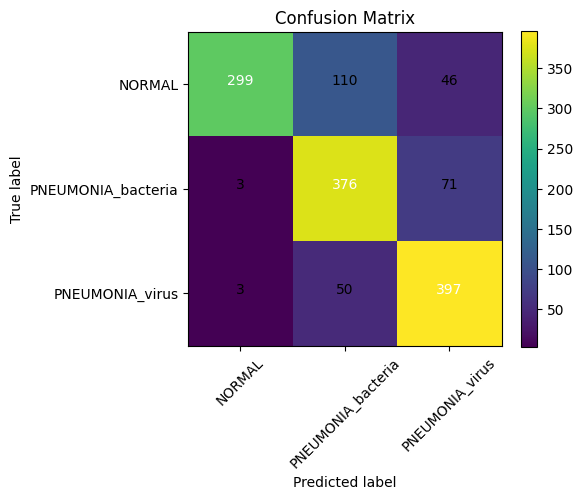

In [14]:
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=list(CLASSES)))

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(len(CLASSES))
plt.xticks(ticks, CLASSES, rotation=45); plt.yticks(ticks, CLASSES)
thr = cm.max()/2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]}", ha="center", color="white" if cm[i,j]>thr else "black")
plt.ylabel("True label"); plt.xlabel("Predicted label"); plt.tight_layout(); 
plt.show()

## 9. roc_auc của model (trên test)

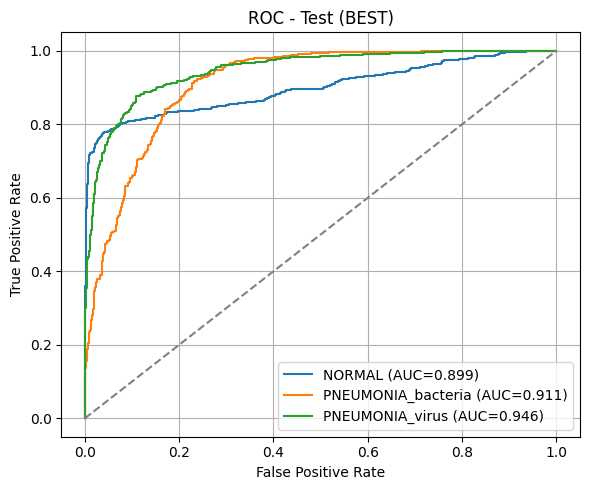

In [17]:
from sklearn.metrics import roc_curve, auc
y_true_idx = []
y_prob = []

for bx, by in test_ds:
    probs = best.predict(bx, verbose=0)     # (batch, num_classes)
    y_prob.append(probs)
    y_true_idx.extend(np.argmax(by.numpy(), axis=1))

y_prob = np.vstack(y_prob)                   # (N, C)
y_true_idx = np.array(y_true_idx)            # (N,)

labels = list(CLASSES)

# Vẽ ROC từng lớp (one-vs-rest)
plt.figure(figsize=(6,5))
for i, name in enumerate(labels):
    fpr, tpr, _ = roc_curve((y_true_idx == i).astype(int), y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Test (BEST)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. CẤU HÌNH GRAD-CAM VÀ TEST ẢNH CHO MODEL

In [84]:
import os, glob, random, matplotlib.pyplot as plt
TEST_DIR = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test"
LAST_CONV_DEFAULT = "block14_sepconv2_act"  # lớp conv cuối của Xception

1. Hiển thị Grad-CAM 2 cột: Ảnh gốc - Grad-CAM

In [ ]:
def show_gradcam_simple(img_path, alpha=0.5, last_conv_name=None, figsize=(12,5)):
#Hiển thị Grad-CAM dạng 2 cột 
    model_gc = best
    last_conv = last_conv_name or pick_last_conv(model_gc, LAST_CONV_DEFAULT)

# Load ảnh + tính heatmap
    rgb, batch = load_rgb_and_batch(img_path)
    heatmap, pred_idx, probs = make_gradcam_heatmap(model_gc, batch, last_conv)
    pred_name = CLASSES[pred_idx]
    p = float(probs[pred_idx])
# Overlay
    h, w = rgb.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    heatmap_255 = np.uint8(255 * heatmap)
    cmap = cv2.applyColorMap(heatmap_255, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(rgb, 1 - alpha, cmap, alpha, 0)

# Vẽ 2 cột
    plt.figure(figsize=figsize)
    plt.subplot(1,2,1); plt.imshow(rgb);     plt.axis("off"); plt.title("Ảnh gốc", fontsize=18)
    plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off"); 
    plt.title(f"Grad-CAM cho {pred_name} ({p:.2f})", fontsize=18)
    plt.tight_layout(); plt.show()

    return pred_name, p

2. Demo: Chọn ảnh ngẫu nhiên và hiển thị Grad-CAM

Ảnh chọn: C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\NORMAL\Normal-10069.png


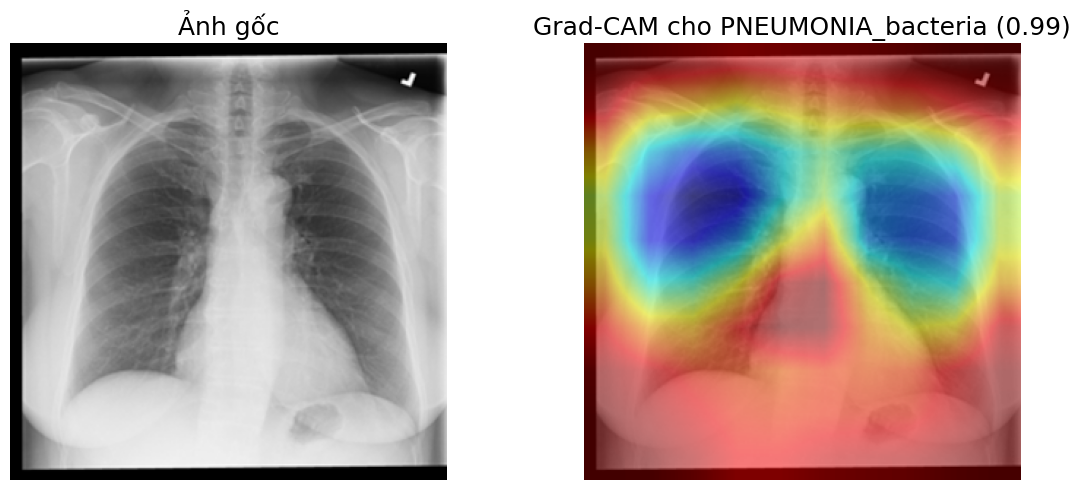

In [ ]:
#  Chọn 1 ảnh bất kỳ trong thư mục TEST
def pick_random_test_image(root=TEST_DIR, classes=CLASSES):
    all_paths = []
    for cls in classes:
        all_paths += glob.glob(os.path.join(root, cls, "*"))
    return random.choice(all_paths)

rand_path = pick_random_test_image(TEST_DIR, CLASSES)
print("Ảnh chọn:", rand_path)
_ = show_gradcam_simple(rand_path, alpha=0.5)

## 11. Xuất toàn bộ TEST có GradCam gồm class/correct|wrong

In [ ]:
TEST_DIR = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\HoangAnh\chest_xray_v2\test"

# 1) Lấy danh sách lớp
if 'CLASSES' in globals() and CLASSES:
    classes = list(CLASSES)
else:
    # fallback: đọc tên thư mục con trong TEST_DIR
    classes = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])

cls2idx = {c: i for i, c in enumerate(classes)}
idx2cls = {i: c for c, i in cls2idx.items()}

# 2) Gom toàn bộ file + vector nhãn thật (từ tên thư mục)
filelist = []
y_true_idx = []
for c in classes:
    paths = glob.glob(os.path.join(TEST_DIR, c, "*"))
    paths.sort()
    filelist.extend(paths)
    y_true_idx.extend([cls2idx[c]] * len(paths))

y_true = np.array(y_true_idx, dtype=int)
# xóa khi xong

1. Tạo thư mục class/correct & class/wrong

In [ ]:
OUT_PAIRS = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs"
os.makedirs(OUT_PAIRS, exist_ok=True)

for c in classes:
    os.makedirs(os.path.join(OUT_PAIRS, c, "correct"), exist_ok=True)
    os.makedirs(os.path.join(OUT_PAIRS, c, "wrong"),   exist_ok=True)

print("Classes:", classes)
print("Total test images:", len(filelist))

Classes: ['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']
Total test images: 1356


2. Xác định lại lớp cuối của Xception

In [78]:
last_conv = pick_last_conv(best, "block14_sepconv2_act")

3. Hàm vẽ và lưu ảnh kiểu 2 cột

In [79]:
def save_gradcam_pair_2col(img_path, true_idx, alpha=0.5, figsize=(8,4)):
    rgb, batch = load_rgb_and_batch(img_path)
    heatmap, pred_idx, probs = make_gradcam_heatmap(best, batch, last_conv)

    true_cls = idx2cls[int(true_idx)]
    pred_cls = idx2cls[int(pred_idx)]
    prob     = float(probs[pred_idx])
    is_correct = (pred_cls == true_cls)

    # overlay
    h, w = rgb.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    cmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(rgb, 1 - alpha, cmap, alpha, 0)

    # vẽ figure 2 cột
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(rgb);     ax[0].set_title("Ảnh gốc", fontsize=15); ax[0].axis("off")
    ax[1].imshow(overlay); ax[1].set_title(f"Grad-CAM cho {pred_cls} ({prob:.2f})", fontsize=15); ax[1].axis("off")
    plt.tight_layout()

    # lưu file
    out_dir = os.path.join(OUT_PAIRS, true_cls, "correct" if is_correct else "wrong")
    os.makedirs(out_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_path = os.path.join(out_dir, f"{base}__true-{true_cls}__pred-{pred_cls}__p={prob:.2f}.jpg")
    plt.savefig(out_path, bbox_inches="tight")
    plt.close(fig)
    return out_path, is_correct

4. Chạy toàn bộ test set

In [80]:
# --- Chạy toàn bộ ---
correct = 0
for i, (p, t) in enumerate(zip(filelist, y_true), 1):
    try:
        out_path, ok = save_gradcam_pair_2col(p, t, alpha=0.5)
        correct += int(ok)
        if i % 20 == 0 or i == len(filelist):
            print(f"[{i}/{len(filelist)}] saved → {out_path}")
    except Exception as e:
        print(f"[{i}] Skip {p} -> {e}")

print(f"\n lưu tại to: {OUT_PAIRS}")
print(f"Accuracy: {correct}/{len(filelist)} ({correct/len(filelist):.2%})")

[20/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\correct\IM-0027-0001__true-NORMAL__pred-NORMAL__p=0.97.jpg
[40/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\correct\IM-0063-0001__true-NORMAL__pred-NORMAL__p=1.00.jpg
[60/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\correct\IM-0097-0001__true-NORMAL__pred-NORMAL__p=0.77.jpg
[80/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\correct\NORMAL2-IM-0035-0001__true-NORMAL__pred-NORMAL__p=0.98.jpg
[100/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\correct\NORMAL2-IM-0107-0001__true-NORMAL__pred-NORMAL__p=0.99.jpg
[120/1356] saved → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\outputs\gradcam_pairs\NORMAL\wrong\NORMAL2-IM-0195-0001__true-NORMAL__pred

## 12. xác thực chéo bằng Stratified K-Fold

1. Thư viện bổ sung

In [1]:
import os, glob, numpy as np
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import Xception

2. Thư mục dữ liệu

In [2]:
DATA_DIR = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")  
TEST_DIR  = os.path.join(DATA_DIR, "test")

3. Lấy danh sách lớp theo train/

In [3]:
CLASSES = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
cls2idx = {c:i for i,c in enumerate(CLASSES)}
idx2cls = {i:c for c,i in cls2idx.items()}
print("CLASSES:", CLASSES)

CLASSES: ['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']


4. Gom toàn bộ file từ train/ + val/ 

In [5]:
def collect_files_labels(root):
    files, labels = [], []
    for c in CLASSES:
        ps = glob.glob(os.path.join(root, c, "*"))
        files.extend(ps)
        labels.extend([cls2idx[c]] * len(ps))
    return np.array(files), np.array(labels, dtype=int)

train_files, train_y = collect_files_labels(TRAIN_DIR)

# gộp thêm val vào tập huấn luyện để K-fold
if os.path.isdir(VAL_DIR):
    val_files, val_y = collect_files_labels(VAL_DIR)
    train_files = np.concatenate([train_files, val_files])
    train_y     = np.concatenate([train_y,     val_y])

print("Total samples for CV:", len(train_files))

Total samples for CV: 10456


5. Tạo tf.data.Dataset từ danh sách file (từ files, labels tạo pipeline vào model)

In [6]:
# kích thước ảnh đầu vào
IMG_SIZE   = (299, 299)
BATCH_SIZE = 16
SEED       = 42

In [8]:
def decode_and_preprocess(path, label):
    img = tf.io.read_file(path)   # đọc file
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = xception_preprocess(img)     # chuẩn hóa theo Xception
    lbl = tf.one_hot(label, depth=len(CLASSES))   # one-hot label
    return img, lbl

def make_ds_from_files(files, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

6. Hàm build model Xception 224 

In [9]:
 # xây head đơn giản, ít tham số
 
def build_xception_light(num_classes=len(CLASSES), dropout=0.3, l2=5e-6, dense_units=96):
    base = Xception(include_top=False, weights="imagenet", input_shape=IMG_SIZE + (3,))
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(base.input, out, name="xception_pneu_224")
    model.compile(optimizer=tf.keras.optimizers.Adam(7e-4), loss="categorical_crossentropy",metrics=["accuracy"])
    
    return model

7. Huấn luyện Stratified K-Fold (K=5) 

In [ ]:
K = 5
EPOCHS_PHASE1 = 10     
EPOCHS_FINETUNE = 4    # mở ít lớp cuối

PROJECT_DIR = os.path.join(os.path.dirname(DATA_DIR), "xception_project")
CKPT_DIR    = os.path.join(PROJECT_DIR, "checkpoints_kfold")
os.makedirs(CKPT_DIR, exist_ok=True)

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
fold_metrics = []

In [12]:
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
fold_metrics = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_files, train_y), 1):
    print(f"\n FOLD {fold}/{K}")
    tr_files, tr_labels = train_files[tr_idx], train_y[tr_idx]
    va_files, va_labels = train_files[va_idx], train_y[va_idx]

    ds_tr = make_ds_from_files(tr_files, tr_labels, shuffle=True)
    ds_va = make_ds_from_files(va_files, va_labels, shuffle=False)

    model = build_xception_light()

    ckpt_path = os.path.join(CKPT_DIR, f"xception_k{K}_fold{fold}_best.h5")
    cb = [
# lưu model tốt nhất (theo val_accuracy)
        ModelCheckpoint(ckpt_path, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
# dừng sớm khi val_acc không tăng
        EarlyStopping(monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True, verbose=1),
# giảm LR khi val_loss không giảm
        ReduceLROnPlateau(monitor="val_loss", mode="min", factor=0.3, patience=2, min_lr=1e-6, verbose=1)]
# giai đoạn 1: train head 
    hist1 = model.fit(ds_tr, validation_data=ds_va,
                      epochs=EPOCHS_PHASE1, callbacks=cb, verbose=1)

# giao đoạn 2 2: fine-tune vài lớp cuối
    base = model.layers[1]                       # backbone Xception
    if hasattr(base, "layers"):
        total = len(base.layers)
        for i, layer in enumerate(base.layers):
            layer.trainable = (i >= total - 10)  # mở 10 lớp cuối cùng
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    hist2 = model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS_FINETUNE, callbacks=cb, verbose=1)


 FOLD 1/5
Epoch 1/10
523/523 [==============================] - ETA: 0s - loss: 0.5664 - accuracy: 0.7487
Epoch 1: val_accuracy improved from -inf to 0.80354, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold1_best.h5
523/523 [==============================] - 397s 757ms/step - loss: 0.5664 - accuracy: 0.7487 - val_loss: 0.4594 - val_accuracy: 0.8035 - lr: 7.0000e-04
Epoch 2/10
523/523 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.7771
Epoch 2: val_accuracy did not improve from 0.80354
523/523 [==============================] - 400s 764ms/step - loss: 0.4994 - accuracy: 0.7771 - val_loss: 0.4546 - val_accuracy: 0.7983 - lr: 7.0000e-04
Epoch 3/10
523/523 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.7952
Epoch 3: val_accuracy did not improve from 0.80354
523/523 [==============================] - 401s 767ms/step - loss: 0.4716 - accuracy: 0.7952 - val_loss: 0.4712 - val_accu

10. Đánh giá fold tốt nhất

In [16]:
val_loss, val_acc = model.evaluate(ds_va, verbose=0)
fold_metrics.append(val_acc)
print(f"[FOLD {fold}] Val Accuracy: {val_acc:.4f}  (ckpt: {ckpt_path})")

[FOLD 5] Val Accuracy: 0.8412  (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold5_best.h5)


11. Tổng quan

In [19]:
print("\n K-FOLD SUMMARY ")
print("Acc per fold:", [f"{a:.4f}" for a in fold_metrics])
print(f"Mean Acc: {np.mean(fold_metrics):.4f}  ± {np.std(fold_metrics):.4f}")


 K-FOLD SUMMARY 
Acc per fold: ['0.8412', '0.8412']
Mean Acc: 0.8412  ± 0.0000


12. Chọn FOLD tốt nhất và test hết trên bộ test 

In [18]:
# Chọn fold có val_acc cao nhất
best_fold = int(np.argmax(fold_metrics)) + 1
best_ckpt = os.path.join(CKPT_DIR, f"xception_k{K}_fold{best_fold}_best.h5")
print("Best fold:", best_fold, "→", best_ckpt)

Best fold: 1 → C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold1_best.h5


13. Đánh giá 5 Fold

In [ ]:
fold_metrics = []
# Đánh giá 5 fold
for fold in range(1, 6):
    ckpt_path = os.path.join(CKPT_DIR, f"xception_k5_fold{fold}_best.h5")

    # Load model và tạo test dataset tương ứng
    model = load_model(ckpt_path, compile=False)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    ds_test = make_ds_eval(model, test_files, test_labels)

    # Đánh giá
    val_loss, val_acc = model.evaluate(ds_test, verbose=0)
    fold_metrics.append(val_acc)
    print(f"[FOLD {fold}] Test Accuracy: {val_acc:.4f}   (ckpt: {ckpt_path})")

# Tổng hợp chung
print("\n=== K-FOLD SUMMARY ===")
print("Acc per fold:", [f"{a:.4f}" for a in fold_metrics])
print(f"Mean Acc: {np.mean(fold_metrics):.4f} ± {np.std(fold_metrics):.4f}")

[FOLD 1] Test Accuracy: 0.7646   (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold1_best.h5)
[FOLD 2] Test Accuracy: 0.7852   (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold2_best.h5)
[FOLD 3] Test Accuracy: 0.7675   (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold3_best.h5)
[FOLD 4] Test Accuracy: 0.7638   (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold4_best.h5)
[FOLD 5] Test Accuracy: 0.7720   (ckpt: C:\Users\VACB\OneDrive\Desktop\xception_v2\xception_project\checkpoints_kfold\xception_k5_fold5_best.h5)

=== K-FOLD SUMMARY ===
Acc per fold: ['0.7646', '0.7852', '0.7675', '0.7638', '0.7720']
Mean Acc: 0.7706 ± 0.0078
